In [1]:
%load_ext autoreload
%autoreload 2

from torch.utils.data import DataLoader, Dataset
import torch

import sys
sys.path.append('../')
import os

from cont_speech_experiment import ContinuousSpeechExperiment, ClasswiseDataset
from nupic.research.support import parse_config

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_dir = "/home/ec2-user/nta/data/data_classes/"
test_dir = "/home/ec2-user/nta/data/"
config_file = "../experiments.cfg"
exp = "SuperSparseCNN2"
config_init = parse_config(config_file)
config = config_init[exp]
config["name"] = exp
config["seed"] = np.random.randint(0,200)
config["data_dir"] = data_dir
config["batch_size"] = 32
config["num_classes"] = 11
config["freeze_params"] = "output"

# config["cnn_out_channels"] = (128, 64)
# config["cnn_weight_sparsity"] = (0.25, 0.2)
# config["cnn_percent_on"] = (0.047, 0.125)


config["boost_strength"] = -1.5
config["boost_strength_factor"] = -0.9

experiment = ContinuousSpeechExperiment(config=config)

model on GPU
Creating optimizer with learning rate= 0.01


In [3]:
accs = [] # test loss
ent = [] # entropy
class_acc = []
t_acc = []
grads = []

np.random.seed(np.random.randint(0,100))
train_labels = np.reshape(np.random.permutation(np.arange(1,11)), (5,2))

epochs = 1
indices = []


for label in train_labels:
    print("training on class {}".format(label))
    
    indices = np.hstack([0,np.delete(train_labels,np.where(train_labels==label)[0],axis=0).flatten()])
    
    for epoch in range(epochs):
        print("training: epoch {}".format(epoch+1))
        experiment.train(epoch, label, indices)   
            
#         print(torch.max(experiment.model.output.weight.grad[indices,:]))
        
        mt = experiment.test()
        t_acc.append(mt["mean_accuracy"])

#         grads.append(experiment.model.output.weight.grad.cpu().numpy())

    ct = [experiment.test_class(k)["mean_accuracy"] for k in range(1,11)]
    class_acc.append(ct)

    t = experiment.test()
    print("Mean accuracy: {}".format(t["mean_accuracy"]))
    accs.append(t["mean_accuracy"])
    ent.append(np.round(t["entropy"]))

training on class [10  2]
training: epoch 1
Mean accuracy: 19.396551724137932
training on class [3 9]
training: epoch 1
Mean accuracy: 18.926332288401255
training on class [4 1]
training: epoch 1
Mean accuracy: 20.141065830721004
training on class [5 7]
training: epoch 1
Mean accuracy: 19.396551724137932
training on class [6 8]
training: epoch 1
Mean accuracy: 19.63166144200627


/home/ec2-user/miniconda3/envs/nupic.research/lib/python3.7/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


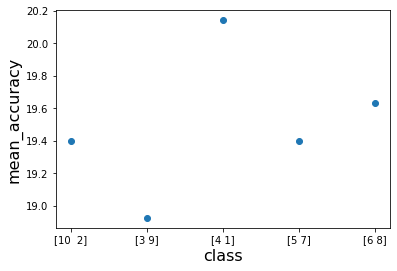

In [4]:
plt.plot(accs,'o')
plt.xlabel('class', fontsize=16)
plt.ylabel('mean_accuracy', fontsize=16)
plt.xticks(range(5),labels=train_labels);
# plt.ylim((5.,25.));

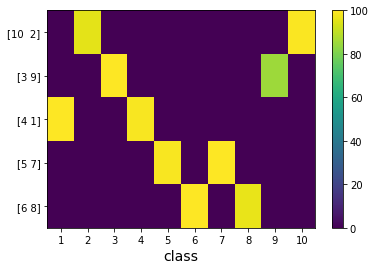

In [5]:
plt.imshow(class_acc, aspect="auto")
plt.yticks(range(5),labels=train_labels)
plt.xticks(range(10), range(1,11));
plt.xlabel("class", fontsize=14)
plt.colorbar();

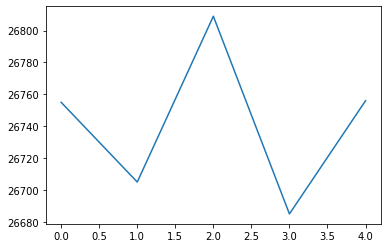

In [6]:
plt.plot(ent)

In [7]:
act = {}
def get_act(name):
    def hook(model, input_, output):
        act[name] = output.detach().cpu().numpy()
    return hook

model = experiment.model

In [8]:
cnt = 0
layer_list = list(model.named_children())
k = [x[0] for x in layer_list]

for module in model:
    module.register_forward_hook(get_act(k[cnt]))
    cnt += 1
    
outputs = []
for k in range(1,11):
    act = {}
    loader = experiment.test_loader[k]
    x,_ = next(iter(loader))
    model(x.cuda())
    outputs.append(act)
    
all_keys = outputs[0].keys()
all_keys

dict_keys(['cnn1_cnn', 'cnn1_bn', 'cnn1_kwinner', 'cnn1_maxpool', 'cnn2_cnn', 'cnn2_bn', 'cnn2_kwinner', 'cnn2_maxpool', 'flatten', 'linear1', 'linear1_bn', 'linear1_kwinners', 'output', 'softmax'])

In [9]:
corr_mats = []
dot_mats = []

for key in all_keys:
    mod_output = [np.vstack([outputs[n][key][k,:].flatten() for k in range(experiment.batch_size)])
                  for n in range(len(outputs))]

    corr_mat = np.zeros((10,10))
    iu = np.triu_indices(experiment.batch_size,1)
    dot_mat = np.zeros((10,10))
    
    m_len = mod_output[0].shape[1]

    for i in range(10):
        for j in range(10):
            corr_mat[i,j] = np.corrcoef(mod_output[i], mod_output[j])[iu].mean()
            
            dot_mat[i,j] = np.mean([np.dot(mod_output[i][x,:],mod_output[j][y,:])/m_len
                                    for x in range(experiment.batch_size) for y in range(experiment.batch_size)])
            
    corr_mats.append(corr_mat)
    dot_mats.append(dot_mat)
    
    
    

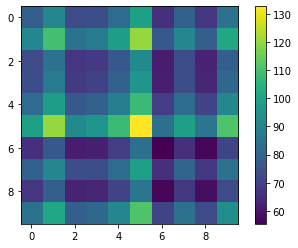

In [10]:
plt.imshow(dot_mat)
plt.colorbar()

In [11]:
ccs = [np.mean(np.triu(k,1)) for k in corr_mats]

Text(0, 0.5, 'Pearson correlation')

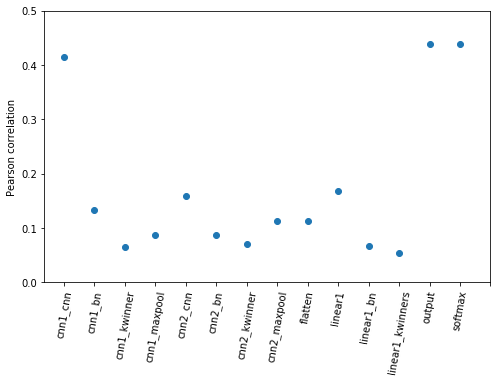

In [12]:
plt.figure(figsize=(8,5))
plt.plot(ccs, 'o')
plt.xticks(np.arange(15), all_keys, rotation=80);
plt.ylim((0., 0.5))
plt.ylabel("Pearson correlation")

In [13]:
ds = [np.mean(np.triu(k,0)) for k in dot_mats]

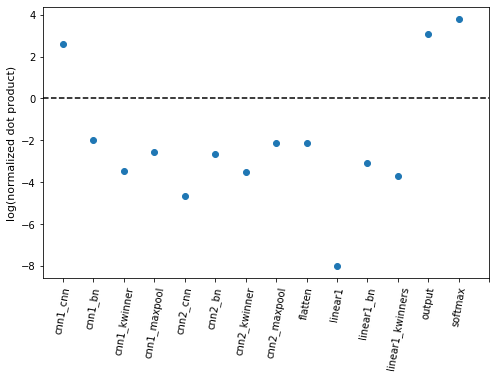

In [14]:
plt.figure(figsize=(8,5))
plt.plot(np.log(ds), 'o')
plt.xticks(np.arange(15), all_keys, rotation=80);
plt.ylabel("log(normalized dot product)", fontsize=11)
# plt.ylim((-7, 5))
plt.axhline(0, color='k', linestyle='--')

In [149]:
torch.index_select?

In [68]:
from torch import optim

In [69]:
torch